In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
from torchvision import datasets, transforms

import tonic
from yingyang.dataset import YinYangDataset

from new_models import SNN, SNN2, SpikeCELoss
from training import train, test, encode_data
import yaml
import random
import snntorch as snn
from tqdm.notebook import tqdm
import pandas as pd
import seaborn as sns


In [2]:
from dataclasses import dataclass
d_args = yaml.safe_load(open('args.yaml', 'r'))
def make_dc(d, name='d_dataclass'):
    @dataclass
    class Wrapped:
        __annotations__ = {k: type(v) for k, v in d.items()}
        
    Wrapped.__qualname__ = Wrapped.__name__ = name

    return Wrapped

args = make_dc(d_args)(**d_args)
d_args

{'T': 30,
 'alpha': 0.01,
 'batch_size': 128,
 'beta': 2,
 'data_folder': '~/SpiNNCloud/Code/data/',
 'dataset': 'mnist',
 'deterministic': False,
 'device': 'cpu',
 'dt': 1,
 'encoding': 'latency_snntorch',
 'epochs': 20,
 'loss_type': 'ce_temporal',
 'lr': 1,
 'model': 'eventprop',
 'mu': [0.05, 1.0],
 'n_hid': None,
 'optimizer': 'sgd',
 'print_freq': 100,
 'resolve_silent': True,
 'seed': 0,
 't_max': None,
 't_min': 2.0,
 'tau_m': 20.0,
 'tau_s': 5.0,
 'xi': 0.4}

In [8]:
torch.manual_seed(args.seed)
np.random.seed(args.seed)
random.seed(args.seed)
args.dataset = 'ying_yang'
if args.deterministic:
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

if args.dataset == "mnist":
    train_dataset = datasets.MNIST(
        args.data_folder, train=True, download=True, transform=transforms.ToTensor()
    )
    test_dataset = datasets.MNIST(
        args.data_folder, train=False, download=True, transform=transforms.ToTensor()
    )
elif args.dataset == "ying_yang":
    train_dataset = YinYangDataset(size=60000, seed=42)
    test_dataset = YinYangDataset(size=10000, seed=40)

else:
    raise ValueError("Invalid dataset name")

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=args.batch_size, shuffle=True, drop_last=True
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=args.batch_size, shuffle=False, drop_last=True
)

model_kwars = {
    "T": args.T,
    "dt": args.dt,
    "tau_m": args.tau_m,
    "tau_s": args.tau_s,
    "mu": args.mu,
    "resolve_silent" : True,
}

n_ins = {"mnist": 784, "ying_yang": 5 if args.encoding == "latency" else 4}
n_outs = {"mnist": 10, "ying_yang": 3}

dims = [n_ins[args.dataset]]
if args.n_hid is not None and isinstance(args.n_hid, list):
    dims.extend(args.n_hid)
elif isinstance(args.n_hid, int):
    dims.append(args.n_hid)
dims.append(n_outs[args.dataset])


In [4]:
snntorch_model =  SNN2(dims, **model_kwars).to(args.device)
eventprop_model = SNN(dims, **model_kwars).to(args.device)
eventprop_model.layers[0].weight.data = snntorch_model.layers[0].weight.data
models = {"snntorch": snntorch_model, "eventprop": eventprop_model}
# [m.eval() for m in models.values()]
[m.layers[0].mu for m in models.values()]

[0.05, 0.05]

In [5]:
counts = [0, 0]
frs = [[], []]
for (data, target), _  in zip(tqdm(test_loader, total=10), range(10)) : 
        
    data, target = data.to(args.device), target.to(args.device)
    spikes_data = encode_data(data, args)
    snn_out = models["snntorch"](spikes_data)
    event_out = models["eventprop"](spikes_data)
    counts = [c + out[0].unique(return_counts=True)[1] for c, out in zip(counts, [snn_out, event_out])]
    [f.append(s[0].float().mean()) for f, s in zip(frs, [snn_out, event_out])]
    

  0%|          | 0/10 [00:00<?, ?it/s]

In [6]:
counts

[tensor([372790,  49610]), tensor([345666,  38334])]

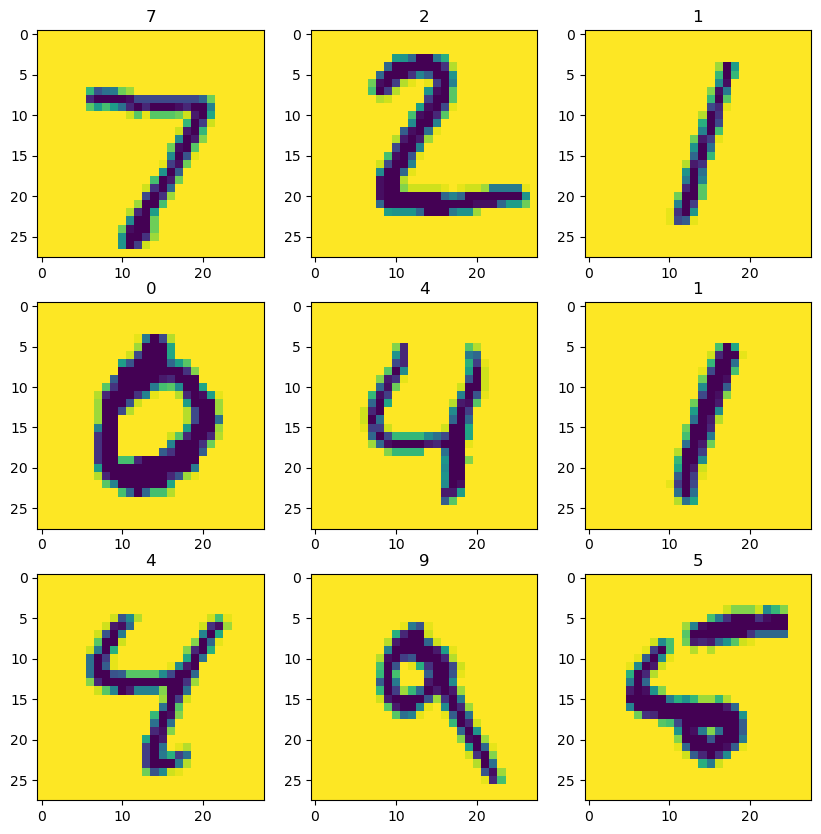

In [7]:
data, target = next(iter(test_loader))
spikes_data = encode_data(data, args)
fig, axs = plt.subplots(3, 3, figsize=(10, 10)) 
for t, s, ax in zip(target[:9], spikes_data.argmax(0), axs.flatten()) : 
    ax.imshow(s.reshape(28, 28))
    ax.set_title(t.item())

In [9]:
plot_data ={k : [] for k in ['sum_x', 'sum_y', 'first_x', 'first_y', 'target']}
args.encoding = 'latency_snntorch'
args.T = 30
for data, target in tqdm(test_loader) :
    spikes_data = encode_data(data, args)
    for u in target.unique() : 
        plot_data['sum_x'].extend(spikes_data[:, target == u].sum(0)[:, 0].tolist())
        plot_data['sum_y'].extend(spikes_data[:, target == u].sum(0)[:, 1].tolist())
        plot_data['first_x'].extend(spikes_data[:, target == u].argmax(0)[:, 0].tolist())
        plot_data['first_y'].extend(spikes_data[:, target == u].argmax(0)[:, 1].tolist())
        plot_data['target'].extend(target[target == u].tolist())

plot_data = pd.DataFrame.from_dict(plot_data)

  0%|          | 0/78 [00:00<?, ?it/s]

<Axes: xlabel='sum_x', ylabel='sum_y'>

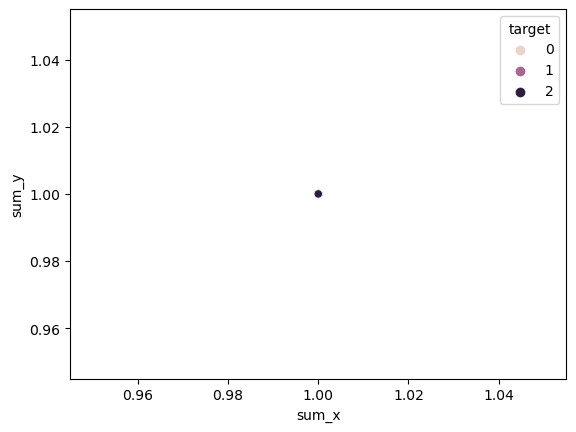

In [11]:
sns.scatterplot(plot_data, x='sum_x', y='sum_y', hue='target')